In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, "data")

In [4]:
left_test_image = cv2.imread(os.path.join(DATA_PATH, "keparoi_left_frame.jpg"))
right_test_image = cv2.imread(os.path.join(DATA_PATH, "keparoi_right_frame.jpg"))

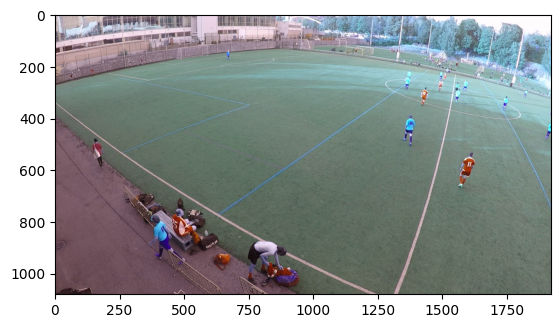

In [6]:
plt.imshow(left_test_image)
plt.show()

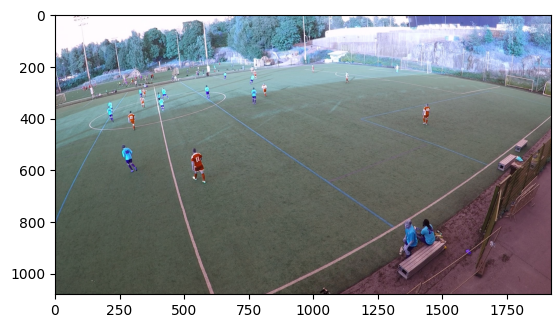

In [7]:
plt.imshow(right_test_image)
plt.show()

In [10]:
video_keparoicam_L = os.path.join(DATA_PATH, "keparoicam_clipL_synchronized.mp4")
video_keparoicam_R = os.path.join(DATA_PATH, "keparoicam_clipR_synchronized.mp4")

video_left_capture = cv2.VideoCapture(video_keparoicam_L)
video_right_capture = cv2.VideoCapture(video_keparoicam_R)

In [11]:
ret_left, left_frame = video_left_capture.read()
ret_right, right_frame = video_right_capture.read()

print(ret_left)
print(ret_right)

video_left_capture.release()
video_right_capture.release()

True
True


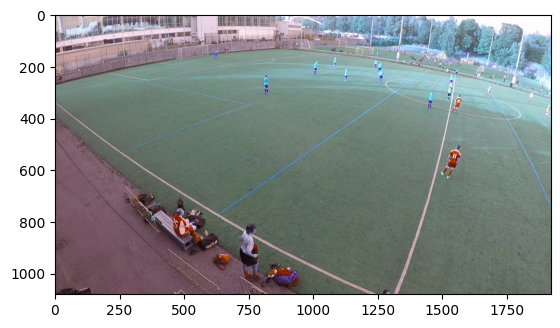

In [12]:
plt.imshow(left_frame)
plt.show()

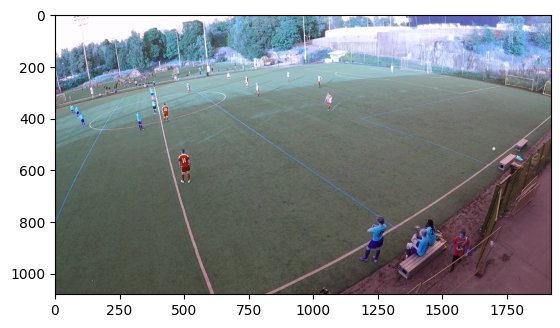

In [21]:
plt.imshow(right_frame)
plt.show()

In [22]:
cv2.imwrite(os.path.join(DATA_PATH, "keparoi_left_frame_aligned.jpg"), left_frame)

True

In [23]:
cv2.imwrite(os.path.join(DATA_PATH, "keparoi_right_frame_aligned.jpg"), right_frame)

True

In [20]:
right_frame.shape

(1080, 1920, 3)

In [58]:
def apply_sift(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    (kps, features) = sift.detectAndCompute(image, None)
    kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

def match_keypoints_and_homography(keypoints1, keypoints2, features1, features2, ratio, reprojection_thresh):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    raw_matches = matcher.knnMatch(features1, features2, 2)
    matches = []
    
    for match in raw_matches:
        if len(match) == 2 and match[0].distance < match[1].distance * ratio:
            matches.append((match[0].trainIdx, match[0].queryIdx))
        
    # computing a homography requires at least 4 matches
    if len(matches) < 4:
        return None
    else:
        # construct the two sets of points
        points1 = np.float32([keypoints1[i] for (_, i) in matches])
        points2 = np.float32([keypoints2[i] for (i, _) in matches])
        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(points1, points2, cv2.RANSAC, reprojection_thresh)
        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)


def cylindrical_warp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    y_i, x_i = np.indices((h_,w_))
    # Convert to homogeneous coordinates
    X = np.stack([x_i, y_i, np.ones_like(x_i)], axis=-1).reshape(h_*w_,3) 
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T
    # Calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    # Project back to image-pixels plane
    B = K.dot(A.T).T 
    # Convert back from homogeneous coordinates
    B = B[:,:-1] / B[:,[-1]]
    # Make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    # For transparent borders
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA)
    # Warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)
    
# K is intrinsic matrix
def stitch_with_cylindrical_projection(image1, image2, K, ratio=0.75, reprojection_thresh=4.0):
    
    image2, image1 = image1, image2
    
    image1_undistorted = cylindrical_warp(image1, K)
    image2_undistorted = cylindrical_warp(image2, K)
    
    plt.imshow(image1_undistorted)
    plt.show()
    
    plt.imshow(image2_undistorted)
    plt.show()
    
    keypoints1, features1 = apply_sift(image1_undistorted)
    keypoints2, features2 = apply_sift(image2_undistorted)
    
    M = match_keypoints_and_homography(keypoints1, keypoints2, features1, features2, ratio, reprojection_thresh)
    
    (matches, H, status) = M

    if M is None:
        return None
    
    result = cv2.warpPerspective(image1_undistorted, M[1],
        (image1_undistorted.shape[1] + image2_undistorted.shape[1], image1_undistorted.shape[0]))
    
    result[0:image2_undistorted.shape[0], 0:image2_undistorted.shape[1]] = image2_undistorted
    
    return result

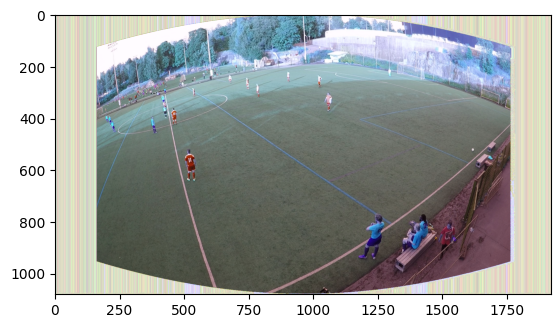

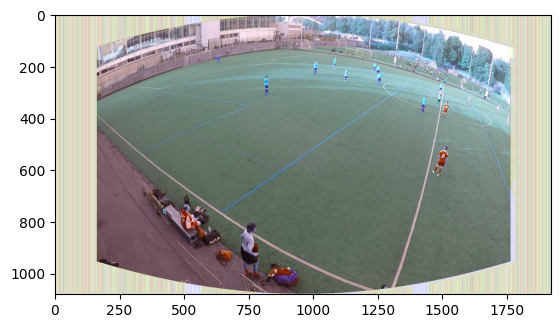

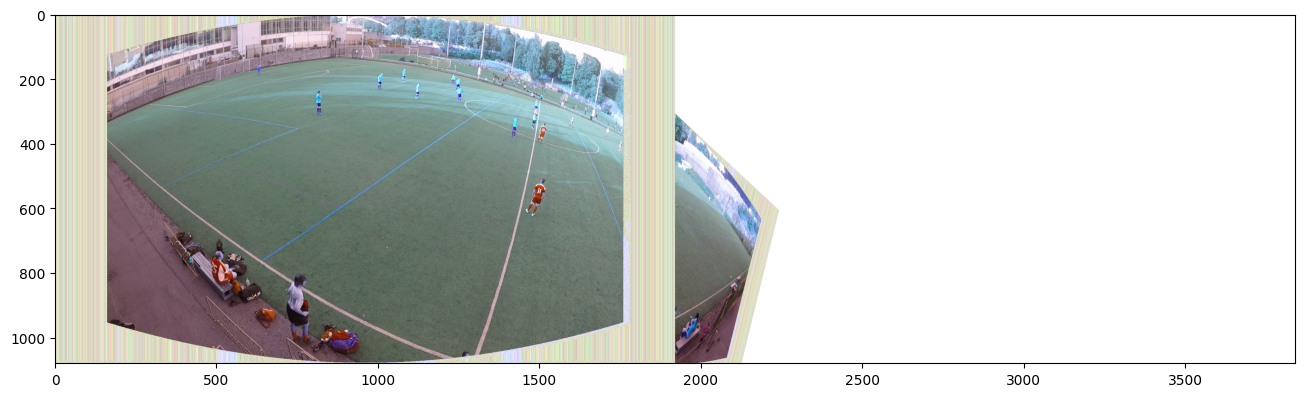

In [59]:
height, width, dim = right_frame.shape

K = np.array([
    [1149, 0, width//2],
    [0, 1556, height//2],
    [0, 0, 1]
])

D = np.array([0, 0, 0, 0])

panorama = stitch_with_cylindrical_projection(left_frame, right_frame, K)
plt.figure(figsize=(16, 16))
plt.imshow(panorama)
plt.show()